# Daily mean pre-processor notebook

##### Authors : Will Wieder wwieder@ucar.edu [@wwieder](https://github.com/wwieder), modified from work by Negin Sobhani negins@ucar.edu [@negin513](https://github.com/negin513), 

##### Last revised: 2023-01-22
_______

This is a notebook for reading NEON simulation and evaluation files and save them as csv files. 

In [1]:
import os
import time
import datetime

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

import xarray as xr

from glob import glob
from os.path import join

import tqdm
import cftime

In [2]:
print('xarray '+xr.__version__) ##-- was working with 0.20.0

xarray 2022.6.0


## Dask Cluster
The following will spin up a dask cluster,  only works on NCAR machines. 
16 workers worked best for NEON.

In [44]:
from distributed import Client
from ncar_jobqueue import NCARCluster

cluster = NCARCluster()
cluster.scale(16)
client = Client(cluster)
client

/glade/u/apps/opt/conda/envs/npl-2022b/lib/python3.8/site-packages/distributed/node.py:179: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 32967 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/nict/proxy/32967/status,
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/nict/proxy/32967/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.12.206.49:36032,Workers: 0
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/nict/proxy/32967/status,Total threads: 0
Started: Just now,Total memory: 0 B


---------------------------

# Import model output

### _only read these variables from the whole netcdf files_


In [2]:
def preprocess (ds):
    '''
    reading ALL variables from ctsm outputs
    '''
    variables = ['QVEGT','QVEGE','QSOIL','RAIN','SNOW','Vcmx25Z',
                 'ELAI','FCEV','FCTR','FGEV','FIRA','FSA','FSR','FSDS',
                 'FSH','FPSN','H2OSOI','SNOW_DEPTH','TBOT','TSOI',
                 'BTRANMN','TV']
    
    ds_new= ds[variables]
    # select 3rd soil layer (for now)
    ds_new['TSOI'] = ds_new['TSOI'].isel(levgrnd=2) - 273.15
    ds_new['H2OSOI'] = ds_new['H2OSOI'].isel(levsoi=2)
    return ds_new

In [3]:
# -- fix timestamp on CTSM files so they can be matched with eval files

def fix_time (ds):
    '''
    fix time formatting with reading multiple cesm files.
    '''
    nsteps = len(ds.time)
    yr0 = ds['time.year'][0].values
    month0 = ds['time.month'][0].values
    day0 = ds['time.day'][0].values

    date = cftime.datetime(yr0,month0,day0).isoformat() 
    ds['time'] = xr.cftime_range(date, periods=nsteps, freq='30min')
    ds['time']= ds['time'].dt.strftime("%Y-%m-%d %H:%M:%S")
    return ds

In [4]:
#-- path to save the csv files:
csv_dir = "/glade/scratch/nict/"

#create the directory if it does not exist:
if not os.path.isdir(csv_dir):
    os.mkdir(csv_dir)

In [5]:
# load CLM5.1-SP simulation output

years = ['2010', '2011', '2012', '2013', '2014', "2015"] # can switch these around to match obs years
neon_site = 'US-NR1_test1_sp'

start_site = time.time()

print ('---------------------------')
print ("Extracting data for "+neon_site)
sim_files =[]

# extract/load model output files
# create list and opens from it


for year in years:
    sim_path = "/glade/scratch/jayka/archive/"+neon_site+"/lnd/hist/"
    sim_files.extend(sorted(glob(join(sim_path,neon_site+".clm2.h1."+year+"*.nc"))))
    

print("All simulation files for all years: [", len(sim_files), "files]")

start = time.time()

# opens list of files, loads to memory

ds_ctsm = xr.open_mfdataset(sim_files, decode_times=True, 
                            combine='by_coords',parallel=True,
                            preprocess=preprocess).load()
ds_ctsm = fix_time (ds_ctsm) # convert to comparable time format 


end = time.time()
print("Reading all simulation files took:", end-start, "s.")

#Convert CTSM data to a Pandas Dataframe for easier handling:
ctsm_vars = list(ds_ctsm.var())

df_ctsm = pd.DataFrame({'time':ds_ctsm.time})
df_ctsm['time'] = pd.to_datetime(df_ctsm['time'],format= '%Y-%m-%d %H:%M:%S' )

# converts variable names with 'sim' prefix

for var in tqdm.tqdm(ctsm_vars):
    sim_var_name = "sim_"+var
    #sim_var_name = var
    field = np.ravel ( ds_ctsm[var])     
    df_ctsm[sim_var_name]=field
    #-- shift simulation data by one time step
    df_ctsm[sim_var_name]=df_ctsm[sim_var_name].shift(-1).values

---------------------------
Extracting data for US-NR1_test1_sp
All simulation files for all years: [ 6 files]
Reading all simulation files took: 3.0693814754486084 s.


100%|██████████| 22/22 [00:00<00:00, 1388.99it/s]


In [45]:
def preprocess (ds):
    '''
    reading ALL variables from ctsm outputs
    '''
    variables = ['QVEGT','QVEGE','QSOIL','RAIN','SNOW',
                 'ELAI','FCEV','FCTR','FGEV','FIRA','FSA','FSR','FSDS',
                 'FSH','FATES_GPP','H2OSOI','SNOW_DEPTH','TBOT','TSOI']
    
    ds_new= ds[variables]
    # select 3rd soil layer (for now)
    ds_new['TSOI'] = ds_new['TSOI'].isel(levgrnd=2) - 273.15
    ds_new['H2OSOI'] = ds_new['H2OSOI'].isel(levsoi=2)
    return ds_new

# load FATES-SP simulation output

years = ['2010', '2011', '2012', '2013', '2014', "2015"] # can switch these around to match obs years
neon_site = 'US-NR1_test_fatesSP'

start_site = time.time()

print ('---------------------------')
print ("Extracting data for "+neon_site)
sim_files =[]

# extract/load model output files
# create list and opens from it


for year in years:
    sim_path = "/glade/scratch/jayka/archive/"+neon_site+"/lnd/hist/"
    sim_files.extend(sorted(glob(join(sim_path,neon_site+".clm2.h1."+year+"*.nc"))))
    

print("All simulation files for all years: [", len(sim_files), "files]")

start = time.time()

# opens list of files, loads to memory

ds_ctsm = xr.open_mfdataset(sim_files, decode_times=True, 
                            combine='by_coords',parallel=True,
                            preprocess=preprocess).load()
ds_ctsm = fix_time (ds_ctsm) # convert to comparable time format 


end = time.time()
print("Reading all simulation files took:", end-start, "s.")

#Convert CTSM data to a Pandas Dataframe for easier handling:
ctsm_vars = list(ds_ctsm.var())

df_fates = pd.DataFrame({'time':ds_ctsm.time})
df_fates['time'] = pd.to_datetime(df_fates['time'],format= '%Y-%m-%d %H:%M:%S' )

# converts variable names with 'sim' prefix

for var in tqdm.tqdm(ctsm_vars):
    sim_var_name = "fates_sim_"+var
    #sim_var_name = var
    field = np.ravel ( ds_ctsm[var])     
    df_fates[sim_var_name]=field
    #-- shift simulation data by one time step
    df_fates[sim_var_name]=df_fates[sim_var_name].shift(-1).values

---------------------------
Extracting data for US-NR1_test_fatesSP
All simulation files for all years: [ 6 files]
Reading all simulation files took: 3.2327656745910645 s.


100%|██████████| 19/19 [00:00<00:00, 1521.59it/s]


# Import obs data

In [7]:
# load US-NR1 tower data
# original name: AMF_US-NR1_FLUXNET_FULLSET_HH_1998-2016_3-5
nr1 = pd.read_csv('/glade/scratch/nict/us-nr1_fullset_1998-2016.csv')
nr1 = pd.DataFrame(nr1)
nr1['TIMESTAMP_START'] = pd.to_datetime(nr1['TIMESTAMP_START'], format='%Y%m%d%H%M')
nr1['TIMESTAMP_END'] = pd.to_datetime(nr1['TIMESTAMP_END'], format='%Y%m%d%H%M')

# extract relevant variables and convert US-NR1 data to single dataframe 
df_af = pd.DataFrame({'time':nr1.TIMESTAMP_START,
                  'nee':nr1.NEE_VUT_REF,
                 'gpp':nr1.GPP_NT_VUT_REF,
                 # 'LE':nr1.LE_F_MDS_QC,
                'LE':nr1.LE_F_MDS,
                 'h':nr1.H_F_MDS,
                'nr':nr1.NETRAD})
df_af = df_af.set_index('time')
df_af = df_af.loc['2010-01-01':'2015-12-31']

# filter net radiation above 0
df_af_filter = df_af[(df_af.nr >= -200)]

# convert units

# convert NEE units from  umolm-2s-1 to gc/m2/s
#df_all ['NEE']= df_all ['NEE']*(12.01/1000000)
#df_all ['GPP']= df_all ['GPP']*(12.01/1000000)
# -- convert gc/m2/s to gc/m2/day
# df_all ['NEE']= df_all['NEE']*60*60*24
# df_all ['GPP']= df_all['GPP']*60*60*24


df_af['nee'] = df_af['nee']*(12.01/1000000)
df_af['gpp'] = df_af['gpp']*(12.01/1000000)

df_af['nee'] = df_af['nee']*60*60*24
df_af['gpp'] = df_af['gpp']*60*60*24

df_af.head(5)

,nee,gpp,LE,h,nr
time,,,,,
2010-01-01 00:00:00,0.448271,-0.204521,-35.6600,-35.2051,-45.39
2010-01-01 00:30:00,-0.243851,0.486259,11.9008,-35.5515,-38.65
2010-01-01 01:00:00,0.902768,-0.656675,11.9685,-35.0673,-50.65
2010-01-01 01:30:00,0.879939,-0.636972,40.9100,-35.5046,-30.82
2010-01-01 02:00:00,0.032168,0.212252,12.2199,-35.2757,-18.63


In [206]:
# divid by 44 if fluxes are too big

In [ ]:
# FPSN = photosynthesis

# Merge and explort .csv

In [74]:
# merge and rename simulation data
df_all=pd.concat([df_ctsm,df_fates], axis=1, join='inner')
df_all = df_all.loc[:,~df_all.columns.duplicated()]
df_all = df_all.set_index('time')
df_all.index = pd.to_datetime(df_all.index)

# -- Latent Heat Flux:
# -- EFLX_LH_TOT = FCEV + FCTR +FGEV (ground, canpoy, and transpiration)
clm_var = 'sim_EFLX_LH_TOT'
df_all [clm_var] = df_all['sim_FCEV']+ df_all['sim_FCTR']+ df_all['sim_FGEV']

clm_var = 'fates_sim_EFLX_LH_TOT'
df_all [clm_var] = df_all['fates_sim_FCEV']+ df_all['fates_sim_FCTR']+ df_all['fates_sim_FGEV']


# -- Net Radiation:
# -- Rnet = FSA-FIRA
clm_var = 'sim_Rnet'
df_all [clm_var] = df_all ['sim_FSA']-df_all['sim_FIRA']

clm_var = 'fates_sim_Rnet'
df_all [clm_var] = df_all ['fates_sim_FSA']-df_all['fates_sim_FIRA']

# -- Net Ecosystem Exchange
# -- NEE = GPP- (AR+HR)
# -- It seems like the sign are opposite so we calculated negative NEE
# clm_var = 'sim_NEE'
# df_all [clm_var] = -(df_all ['sim_GPP']-(df_all['sim_AR']+df_all['sim_HR']))

# -- Convert simulation units:
# df_all['sim_NEE']= df_all['sim_NEE']*60*60*24
# df_all['sim_GPP']= df_all['sim_GPP']*60*60*24
# df_all['sim_AR']= df_all['sim_AR']*60*60*24
# df_all['sim_HR']= df_all['sim_HR']*60*60*24
# df_all['sim_ER']= df_all['sim_HR']+df_all['sim_AR']

# Convert atmospheric temperature from K to Deg C
df_all['sim_TBOT'] = df_all['sim_TBOT'] - 273.15
df_all['fates_sim_TBOT'] = df_all['fates_sim_TBOT'] - 273.15

# Convert photosynthesis from umol m-2 s-1 to to gc/m2/s
df_all['sim_FPSN'] = df_all['sim_FPSN']*(12.01/1000000)
# -- convert gc/m2/s to gc/m2/day
df_all['sim_FPSN'] = df_all['sim_FPSN']*60*60*24

# Convert FATES_GPP from kgc m-2 s-1 to gc/m2/day 
df_all['fates_sim_FATES_GPP'] = df_all['fates_sim_FATES_GPP']*1000
df_all['fates_sim_FATES_GPP'] = df_all['fates_sim_FATES_GPP']*60*60*24

#-- extract year, month, day, hour information from time
df_all['year'] = df_all.index.year
df_all['month'] = df_all.index.month
df_all['day'] = df_all.index.day
df_all['hour'] = df_all.index.hour

# tzone_shift = ds_eval.TimeDiffUtcLt
# hard coded for Mountain time
tzone_shift = -7

# convert to local time
df_all['local_time']= df_all.index + datetime.timedelta(hours=int(tzone_shift))
df_all['local_hour'] = df_all['local_time'].dt.hour
df_all = df_all.set_index('local_time')
df_all = df_all.loc['2010-01-01':'2015-12-31'] # filter time

# merge with AmeriFlux data
# Outer join based on index
df = pd.merge(df_all, df_af, left_index = True, right_index = True,how = "outer") 

# Write out 30 minute data
csv_out = join(csv_dir, "preprocessed_"+neon_site+".csv")
df.to_csv(csv_out,index=False)


# -- Calculate daily means
df['local_time']= df.index + datetime.timedelta(hours=int(tzone_shift))
df['local_hour'] = df['local_time'].dt.hour

df['local_date'] = df['local_time'].astype('M8[D]')
df_day = df.groupby(df['local_date']).mean()
#mask out days with missing values
df_count = df.groupby(df['local_date']).count()
df_day = df_day.where(df_count==48)

# Write out daily minute data
csv_out = join(csv_dir, "mean_daily_"+neon_site+".csv")
df_day.to_csv(csv_out,index=True)

## Plotting

In [75]:
df1 = pd.read_csv('/glade/scratch/nict/mean_daily_US-NR1_test_fatesSP.csv')

df1['time'] = pd.to_datetime(df1['local_date'],format= '%Y-%m-%d' )
df1['time2'] = pd.to_datetime(df1['local_date'],format= '%Y-%m-%d' )
df1['DOY'] = df1['time'].dt.dayofyear
df1 = df1.set_index('time')

# extract relevant variables and drop NANs
# df1 = df1[['sim_GPP','sim_NEE','sim_Rnet','sim_EFLX_LH_TOT','nr','gpp','LE','nee','DOY','time2']].copy()


# remove outliers for net radiation 
# upper_outlier_nr, lower_outlier_nr = df1.nr.quantile(.98), df1.nr.quantile(.02)
# df1 = df1[(df1.nr < upper_outlier_nr) & (df1.nr > lower_outlier_nr)]

# remove extreme values for net radiation 
df1 = df1[(df1.nr >= -200)]

# df1 = df1.dropna()
df1

,local_date,sim_QVEGT,sim_QVEGE,sim_QSOIL,sim_RAIN,sim_SNOW,sim_Vcmx25Z,sim_ELAI,sim_FCEV,sim_FCTR,...,day,hour,local_hour,nee,gpp,LE,h,nr,time2,DOY
time,,,,,,,,,,,,,,,,,,,,,
2010-01-01,2010-01-01,4.846371e-07,1.039172e-06,4.533578e-07,0.0,0.000000,46.054817,0.810829,2.598970,1.212077,...,1.583333,11.5,11.5,0.318833,-0.008748,20.730396,11.781483,26.588375,2010-01-01,1
2010-01-02,2010-01-02,3.191878e-07,1.220768e-06,4.123567e-07,0.0,0.000052,45.783000,0.810671,3.053140,0.798289,...,2.583333,11.5,11.5,0.324372,-0.043569,55.009900,-20.226875,24.845417,2010-01-02,2
2010-01-03,2010-01-03,2.854196e-07,7.848963e-07,4.521671e-07,0.0,0.000005,45.374226,0.810513,1.963026,0.713834,...,3.583333,11.5,11.5,0.287868,-0.031261,19.894917,-4.329604,9.376458,2010-01-03,3
2010-01-04,2010-01-04,4.266065e-07,1.437216e-06,6.400430e-07,0.0,0.000001,45.420082,0.810354,3.594479,1.066943,...,4.583333,11.5,11.5,0.238265,0.055113,15.456104,9.440417,32.030000,2010-01-04,4
2010-01-05,2010-01-05,2.806450e-07,1.573912e-06,4.527619e-07,0.0,0.000034,45.307655,0.810196,3.936354,0.701893,...,5.583333,11.5,11.5,0.318897,-0.035808,44.757006,-23.238042,23.743125,2010-01-05,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-12-26,2015-12-26,3.131650e-07,-2.870263e-07,-1.371218e-07,0.0,0.000000,42.264190,0.811621,-0.717853,0.783226,...,26.583333,11.5,11.5,0.393147,-0.158086,2.456344,0.685771,10.183229,2015-12-26,360
2015-12-27,2015-12-27,4.496382e-07,1.155643e-06,5.147826e-07,0.0,0.000000,41.873390,0.811463,2.890263,1.124545,...,27.583333,11.5,11.5,0.357277,-0.090160,64.301291,-53.836146,17.830417,2015-12-27,361
2015-12-28,2015-12-28,2.785762e-07,7.062222e-07,2.986385e-07,0.0,0.000000,41.943478,0.811304,1.766262,0.696719,...,28.583333,11.5,11.5,0.321485,-0.123250,44.368957,8.091146,35.008333,2015-12-28,362


In [76]:
# Group by DOY and calculate mean and std
climo1 = df1.groupby(df1.time2.dt.dayofyear).mean()
climo1SD = df1.groupby(df1.time2.dt.dayofyear).std()

climo1.var()

sim_QVEGT                4.257594e-11
sim_QVEGE                4.411818e-13
sim_QSOIL                2.014170e-11
sim_RAIN                 4.583457e-10
sim_SNOW                 6.858043e-10
sim_Vcmx25Z              1.097725e+02
sim_ELAI                 7.327873e-02
sim_FCEV                 2.759593e+00
sim_FCTR                 2.663126e+02
sim_FGEV                 1.361340e+02
sim_FIRA                 2.592582e+02
sim_FSA                  3.816691e+03
sim_FSR                  1.328460e+02
sim_FSDS                 4.492552e+03
sim_FSH                  5.562886e+02
sim_FPSN                 3.632343e+00
sim_H2OSOI               3.624319e-03
sim_SNOW_DEPTH           7.157496e-02
sim_TBOT                 6.348632e+01
sim_TSOI                 5.077096e+01
sim_BTRANMN                       NaN
sim_TV                   6.567013e+01
fates_sim_QVEGT          3.291703e-11
fates_sim_QVEGE          4.120872e-13
fates_sim_QSOIL          3.243337e-11
fates_sim_RAIN           4.583457e-10
fates_sim_SN

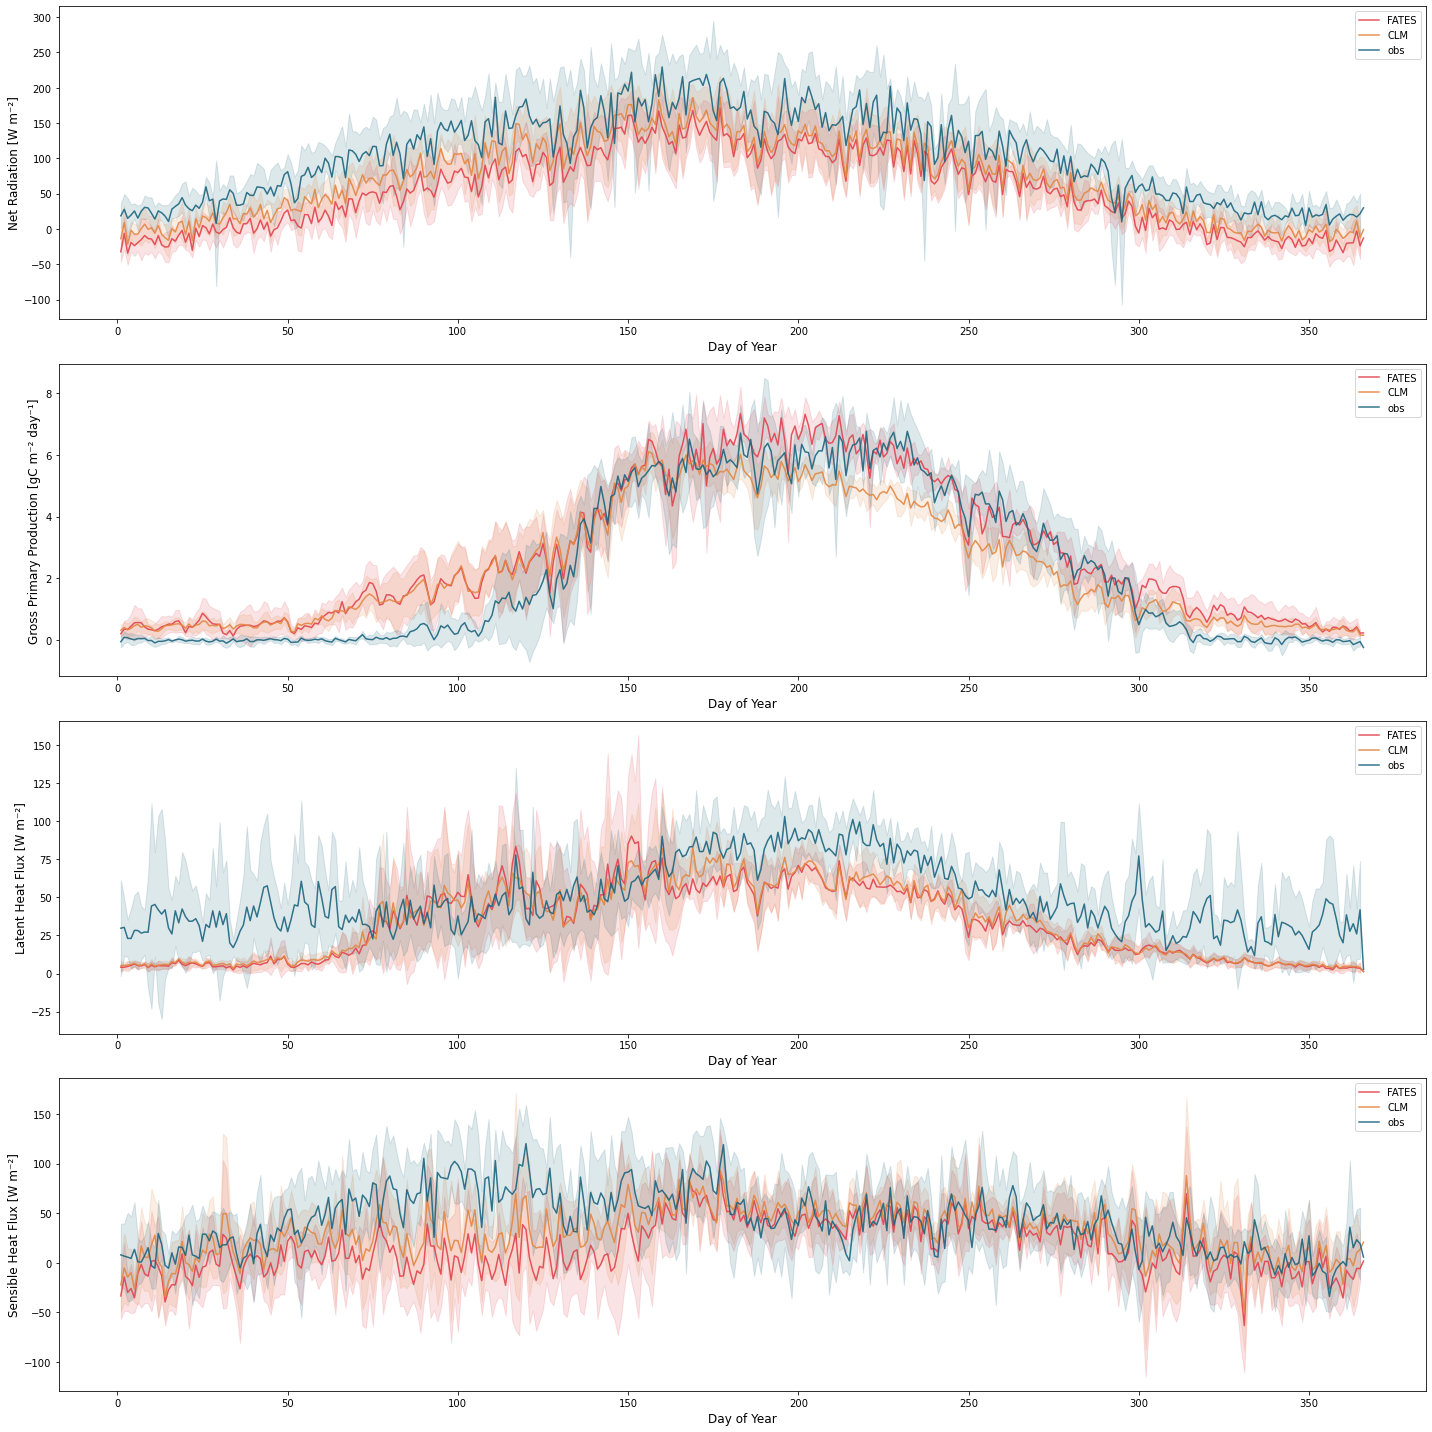

In [81]:
color1='#e28743'
color2='#1d657e'
color3='#E2434F'

plt.figure(figsize=(20, 20),facecolor='w',edgecolor='k')

plt.subplot(4, 1, 1)
plot_var_desc = "Net Radiation"
plot_var_unit= "W m⁻²"

plt.plot(climo1.DOY, climo1['fates_sim_Rnet'], color = color3, label="FATES", alpha = 0.9)
plt.plot(climo1.DOY, climo1['sim_Rnet'], color = color1,label="CLM", alpha = 0.9)
plt.plot(climo1.DOY, climo1['nr'], color = color2, label="obs", alpha = 0.9)

    
plt.fill_between(climo1.DOY, climo1['nr']-climo1SD['nr'], climo1['nr']+climo1SD['nr'],alpha=0.15, color = color2)    
plt.fill_between(climo1.DOY, climo1['fates_sim_Rnet']-climo1SD['fates_sim_Rnet'], climo1['fates_sim_Rnet']+climo1SD['fates_sim_Rnet'],alpha=0.15, color = color3)
plt.fill_between(climo1.DOY, climo1['sim_Rnet']-climo1SD['sim_Rnet'], climo1['sim_Rnet']+climo1SD['sim_Rnet'] ,alpha=0.15, color = color1)

plt.xlabel('Day of Year', fontsize=12)
plt.ylabel(plot_var_desc+" ["+plot_var_unit+"]", fontsize=12)
plt.legend()


plt.subplot(4, 1, 2)
plot_var_desc = "Gross Primary Production"
plot_var_unit= "gC m⁻² day⁻¹"

plt.plot(climo1.DOY, climo1['fates_sim_FATES_GPP'], color = color3, label="FATES", alpha = 0.9)
plt.plot(climo1.DOY, climo1['sim_FPSN'], color = color1,label="CLM", alpha = 0.9)
plt.plot(climo1.DOY, climo1['gpp'], color = color2, label="obs", alpha = 0.9)

plt.fill_between(climo1.DOY, climo1['fates_sim_FATES_GPP']-climo1SD['fates_sim_FATES_GPP'], climo1['fates_sim_FATES_GPP']+climo1SD['fates_sim_FATES_GPP'],alpha=0.15, color = color3)
plt.fill_between(climo1.DOY, climo1['sim_FPSN']-climo1SD['sim_FPSN'], climo1['sim_FPSN']+climo1SD['sim_FPSN'] ,alpha=0.15, color = color1)
plt.fill_between(climo1.DOY, climo1['gpp']-climo1SD['gpp'], climo1['gpp']+climo1SD['gpp'],alpha=0.15, color = color2)    

plt.xlabel('Day of Year', fontsize=12)
plt.ylabel(plot_var_desc+" ["+plot_var_unit+"]", fontsize=12)
plt.legend()


plt.subplot(4, 1, 3)
plot_var_desc = "Latent Heat Flux"
plot_var_unit= "W m⁻²"

plt.plot(climo1.DOY, climo1['fates_sim_EFLX_LH_TOT'], color = color3, label="FATES", alpha = 0.9)
plt.plot(climo1.DOY, climo1['sim_EFLX_LH_TOT'], color = color1,label="CLM", alpha = 0.9)
plt.plot(climo1.DOY, climo1['LE'], color = color2, label="obs", alpha = 0.9)

plt.fill_between(climo1.DOY, climo1['fates_sim_EFLX_LH_TOT']-climo1SD['fates_sim_EFLX_LH_TOT'], climo1['fates_sim_EFLX_LH_TOT']+climo1SD['fates_sim_EFLX_LH_TOT'],alpha=0.15, color = color3)
plt.fill_between(climo1.DOY, climo1['sim_EFLX_LH_TOT']-climo1SD['sim_EFLX_LH_TOT'], climo1['sim_EFLX_LH_TOT']+climo1SD['sim_EFLX_LH_TOT'] ,alpha=0.15, color = color1)
plt.fill_between(climo1.DOY, climo1['LE']-climo1SD['LE'], climo1['LE']+climo1SD['LE'],alpha=0.15, color = color2)    

plt.xlabel('Day of Year', fontsize=12)
plt.ylabel(plot_var_desc+" ["+plot_var_unit+"]", fontsize=12)
plt.legend()


plt.subplot(4, 1, 4)
plot_var_desc = "Sensible Heat Flux"
plot_var_unit= "W m⁻²"

plt.plot(climo1.DOY, climo1['fates_sim_FSH'], color = color3, label="FATES", alpha = 0.9)
plt.plot(climo1.DOY, climo1['sim_FSH'], color = color1,label="CLM", alpha = 0.9)
plt.plot(climo1.DOY, climo1['h'], color = color2, label="obs", alpha = 0.9)

plt.fill_between(climo1.DOY, climo1['fates_sim_FSH']-climo1SD['fates_sim_FSH'], climo1['fates_sim_FSH']+climo1SD['fates_sim_FSH'],alpha=0.15, color = color3)
plt.fill_between(climo1.DOY, climo1['sim_FSH']-climo1SD['sim_FSH'], climo1['sim_FSH']+climo1SD['sim_FSH'] ,alpha=0.15, color = color1)
plt.fill_between(climo1.DOY, climo1['h']-climo1SD['h'], climo1['h']+climo1SD['h'],alpha=0.15, color = color2)    

plt.xlabel('Day of Year', fontsize=12)
plt.ylabel(plot_var_desc+" ["+plot_var_unit+"]", fontsize=12)
plt.legend()



plt.tight_layout()
plt.savefig('/glade/scratch/nict/fates1.png')
plt.show()

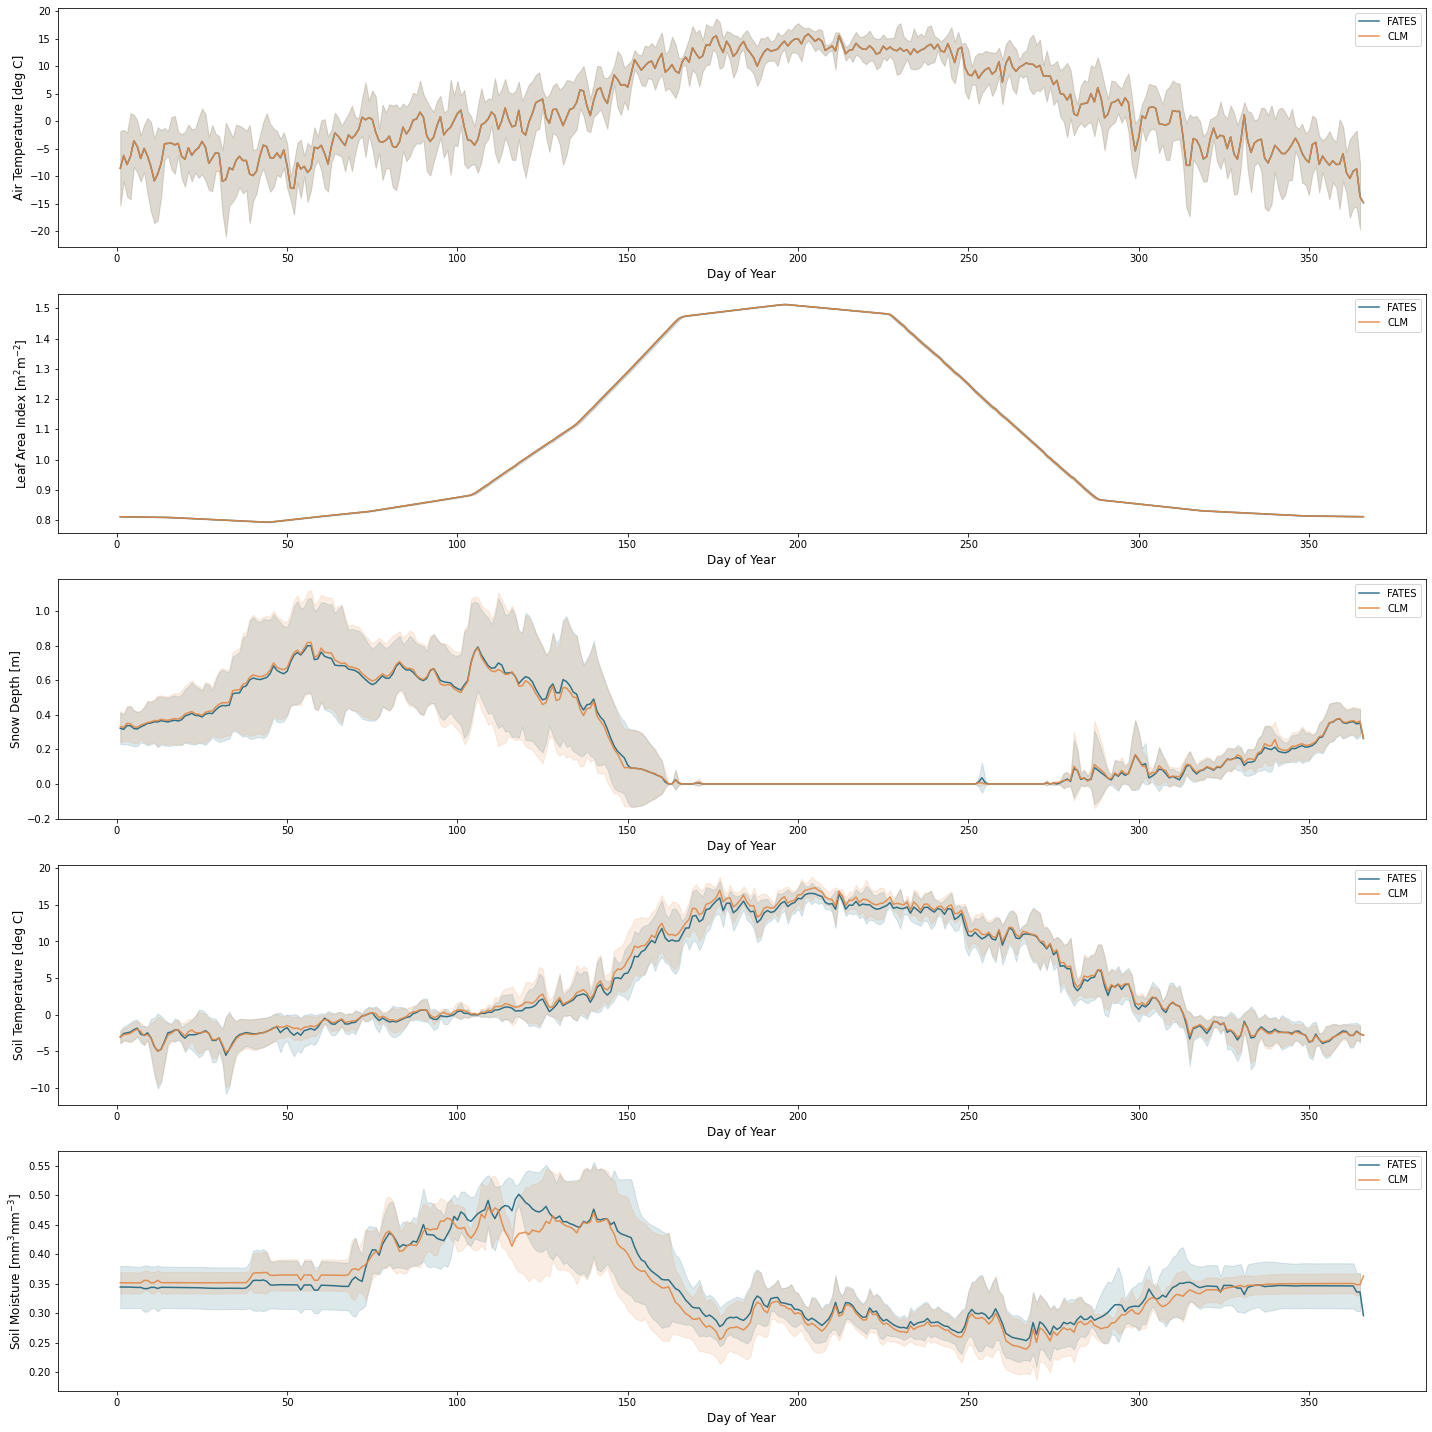

In [82]:
plt.figure(figsize=(20, 20),facecolor='w',edgecolor='k')

plt.subplot(5, 1, 1)
plot_var_desc = "Air Temperature"
plot_var_unit= "deg C"

plt.plot(climo1.DOY, climo1['fates_sim_TBOT'], color = color2, label="FATES", alpha = 0.9)
plt.plot(climo1.DOY, climo1['sim_TBOT'], color = color1,label="CLM", alpha = 0.9)

plt.fill_between(climo1.DOY, climo1['fates_sim_TBOT']-climo1SD['fates_sim_TBOT'], climo1['fates_sim_TBOT']+climo1SD['fates_sim_TBOT'],alpha=0.15, color = color2)
plt.fill_between(climo1.DOY, climo1['sim_TBOT']-climo1SD['sim_TBOT'], climo1['sim_TBOT']+climo1SD['sim_TBOT'] ,alpha=0.15, color = color1)

plt.xlabel('Day of Year', fontsize=12)
plt.ylabel(plot_var_desc+" ["+plot_var_unit+"]", fontsize=12)
plt.legend()



plt.subplot(5, 1, 2)
plot_var_desc = "Leaf Area Index"
plot_var_unit= "$\mathrm{m^{2}  m^{-2}}$"

plt.plot(climo1.DOY, climo1['fates_sim_ELAI'], color = color2, label="FATES", alpha = 0.9)
plt.plot(climo1.DOY, climo1['sim_ELAI'], color = color1,label="CLM", alpha = 0.9)

plt.fill_between(climo1.DOY, climo1['fates_sim_ELAI']-climo1SD['fates_sim_ELAI'], climo1['fates_sim_ELAI']+climo1SD['fates_sim_ELAI'],alpha=0.15, color = color2)
plt.fill_between(climo1.DOY, climo1['sim_ELAI']-climo1SD['sim_ELAI'], climo1['sim_ELAI']+climo1SD['sim_ELAI'] ,alpha=0.15, color = color1)

plt.xlabel('Day of Year', fontsize=12)
plt.ylabel(plot_var_desc+" ["+plot_var_unit+"]", fontsize=12)
plt.legend()



plt.subplot(5, 1, 3)
plot_var_desc = "Snow Depth"
plot_var_unit= "m"

plt.plot(climo1.DOY, climo1['fates_sim_SNOW_DEPTH'], color = color2, label="FATES", alpha = 0.9)
plt.plot(climo1.DOY, climo1['sim_SNOW_DEPTH'], color = color1,label="CLM", alpha = 0.9)

plt.fill_between(climo1.DOY, climo1['fates_sim_SNOW_DEPTH']-climo1SD['fates_sim_SNOW_DEPTH'], climo1['fates_sim_SNOW_DEPTH']+climo1SD['fates_sim_SNOW_DEPTH'],alpha=0.15, color = color2)
plt.fill_between(climo1.DOY, climo1['sim_SNOW_DEPTH']-climo1SD['sim_SNOW_DEPTH'], climo1['sim_SNOW_DEPTH']+climo1SD['sim_SNOW_DEPTH'] ,alpha=0.15, color = color1)

plt.xlabel('Day of Year', fontsize=12)
plt.ylabel(plot_var_desc+" ["+plot_var_unit+"]", fontsize=12)
plt.legend()




plt.subplot(5, 1, 4)
plot_var_desc = "Soil Temperature"
plot_var_unit= "deg C"

plt.plot(climo1.DOY, climo1['fates_sim_TSOI'], color = color2, label="FATES", alpha = 0.9)
plt.plot(climo1.DOY, climo1['sim_TSOI'], color = color1,label="CLM", alpha = 0.9)

plt.fill_between(climo1.DOY, climo1['fates_sim_TSOI']-climo1SD['fates_sim_TSOI'], climo1['fates_sim_TSOI']+climo1SD['fates_sim_TSOI'],alpha=0.15, color = color2)
plt.fill_between(climo1.DOY, climo1['sim_TSOI']-climo1SD['sim_TSOI'], climo1['sim_TSOI']+climo1SD['sim_TSOI'] ,alpha=0.15, color = color1)

plt.xlabel('Day of Year', fontsize=12)
plt.ylabel(plot_var_desc+" ["+plot_var_unit+"]", fontsize=12)
plt.legend()



plt.subplot(5, 1, 5)
plot_var_desc = "Soil Moisture"
plot_var_unit= "$\mathrm{mm^{3}  mm^{-3}}$"

plt.plot(climo1.DOY, climo1['fates_sim_H2OSOI'], color = color2, label="FATES", alpha = 0.9)
plt.plot(climo1.DOY, climo1['sim_H2OSOI'], color = color1,label="CLM", alpha = 0.9)

plt.fill_between(climo1.DOY, climo1['fates_sim_H2OSOI']-climo1SD['fates_sim_H2OSOI'], climo1['fates_sim_H2OSOI']+climo1SD['fates_sim_H2OSOI'],alpha=0.15, color = color2)
plt.fill_between(climo1.DOY, climo1['sim_H2OSOI']-climo1SD['sim_H2OSOI'], climo1['sim_H2OSOI']+climo1SD['sim_H2OSOI'] ,alpha=0.15, color = color1)

plt.xlabel('Day of Year', fontsize=12)
plt.ylabel(plot_var_desc+" ["+plot_var_unit+"]", fontsize=12)
plt.legend()

plt.tight_layout()
plt.savefig('/glade/scratch/nict/fates2.png')
plt.show()

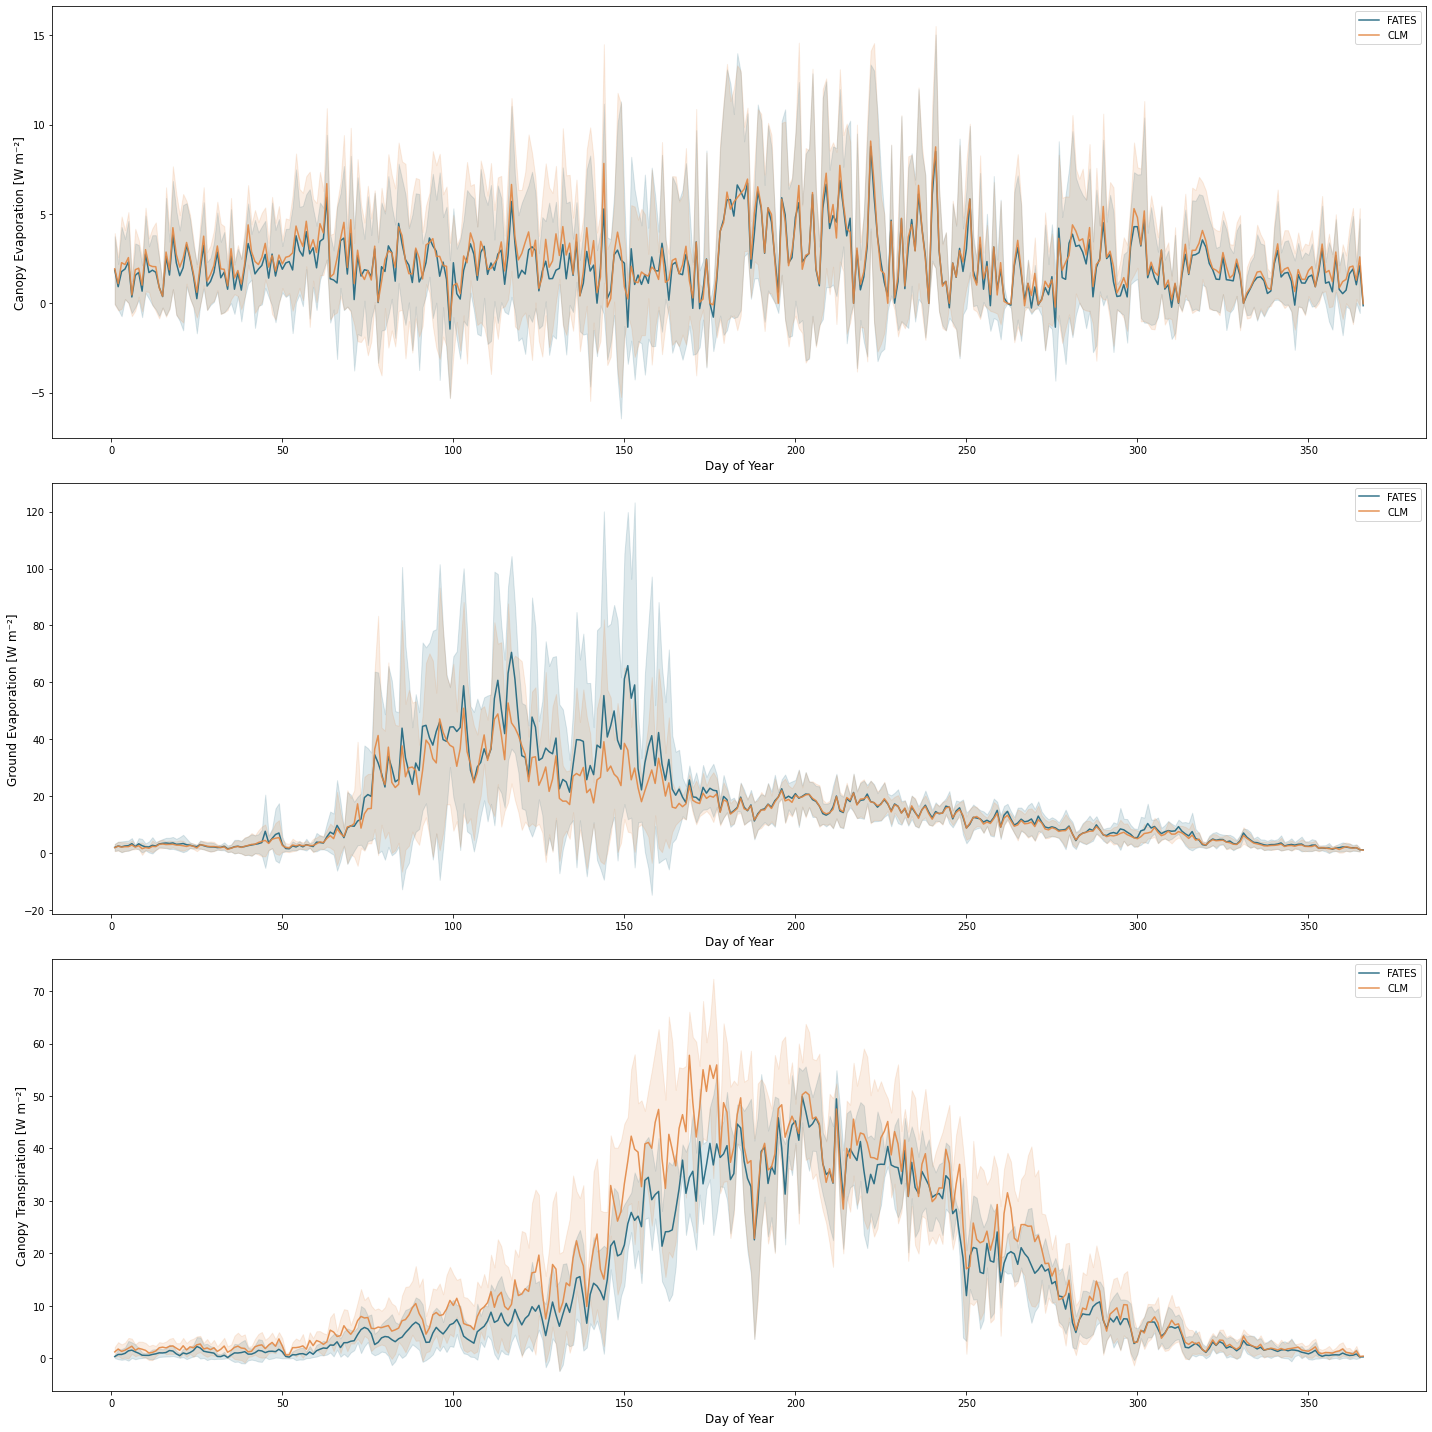

In [83]:
plt.figure(figsize=(20, 20),facecolor='w',edgecolor='k')

plt.subplot(3, 1, 1)
plot_var_desc = "Canopy Evaporation"
plot_var_unit= "W m⁻²"

plt.plot(climo1.DOY, climo1['fates_sim_FCEV'], color = color2, label="FATES", alpha = 0.9)
plt.plot(climo1.DOY, climo1['sim_FCEV'], color = color1,label="CLM", alpha = 0.9)

plt.fill_between(climo1.DOY, climo1['fates_sim_FCEV']-climo1SD['fates_sim_FCEV'], climo1['fates_sim_FCEV']+climo1SD['fates_sim_FCEV'],alpha=0.15, color = color2)
plt.fill_between(climo1.DOY, climo1['sim_FCEV']-climo1SD['sim_FCEV'], climo1['sim_FCEV']+climo1SD['sim_FCEV'] ,alpha=0.15, color = color1)

plt.xlabel('Day of Year', fontsize=12)
plt.ylabel(plot_var_desc+" ["+plot_var_unit+"]", fontsize=12)
plt.legend()

plt.subplot(3, 1, 2)
plot_var_desc = "Ground Evaporation"
plot_var_unit= "W m⁻²"

plt.plot(climo1.DOY, climo1['fates_sim_FGEV'], color = color2, label="FATES", alpha = 0.9)
plt.plot(climo1.DOY, climo1['sim_FGEV'], color = color1,label="CLM", alpha = 0.9)

plt.fill_between(climo1.DOY, climo1['fates_sim_FGEV']-climo1SD['fates_sim_FGEV'], climo1['fates_sim_FGEV']+climo1SD['fates_sim_FGEV'],alpha=0.15, color = color2)
plt.fill_between(climo1.DOY, climo1['sim_FGEV']-climo1SD['sim_FGEV'], climo1['sim_FGEV']+climo1SD['sim_FGEV'] ,alpha=0.15, color = color1)

plt.xlabel('Day of Year', fontsize=12)
plt.ylabel(plot_var_desc+" ["+plot_var_unit+"]", fontsize=12)
plt.legend()


plt.subplot(3, 1, 3)
plot_var_desc = "Canopy Transpiration"
plot_var_unit= "W m⁻²"

plt.plot(climo1.DOY, climo1['fates_sim_FCTR'], color = color2, label="FATES", alpha = 0.9)
plt.plot(climo1.DOY, climo1['sim_FCTR'], color = color1,label="CLM", alpha = 0.9)

plt.fill_between(climo1.DOY, climo1['fates_sim_FCTR']-climo1SD['fates_sim_FCTR'], climo1['fates_sim_FCTR']+climo1SD['fates_sim_FCTR'],alpha=0.15, color = color2)
plt.fill_between(climo1.DOY, climo1['sim_FCTR']-climo1SD['sim_FCTR'], climo1['sim_FCTR']+climo1SD['sim_FCTR'] ,alpha=0.15, color = color1)

plt.xlabel('Day of Year', fontsize=12)
plt.ylabel(plot_var_desc+" ["+plot_var_unit+"]", fontsize=12)
plt.legend()

plt.tight_layout()
plt.savefig('/glade/scratch/nict/fates3.png')
plt.show()

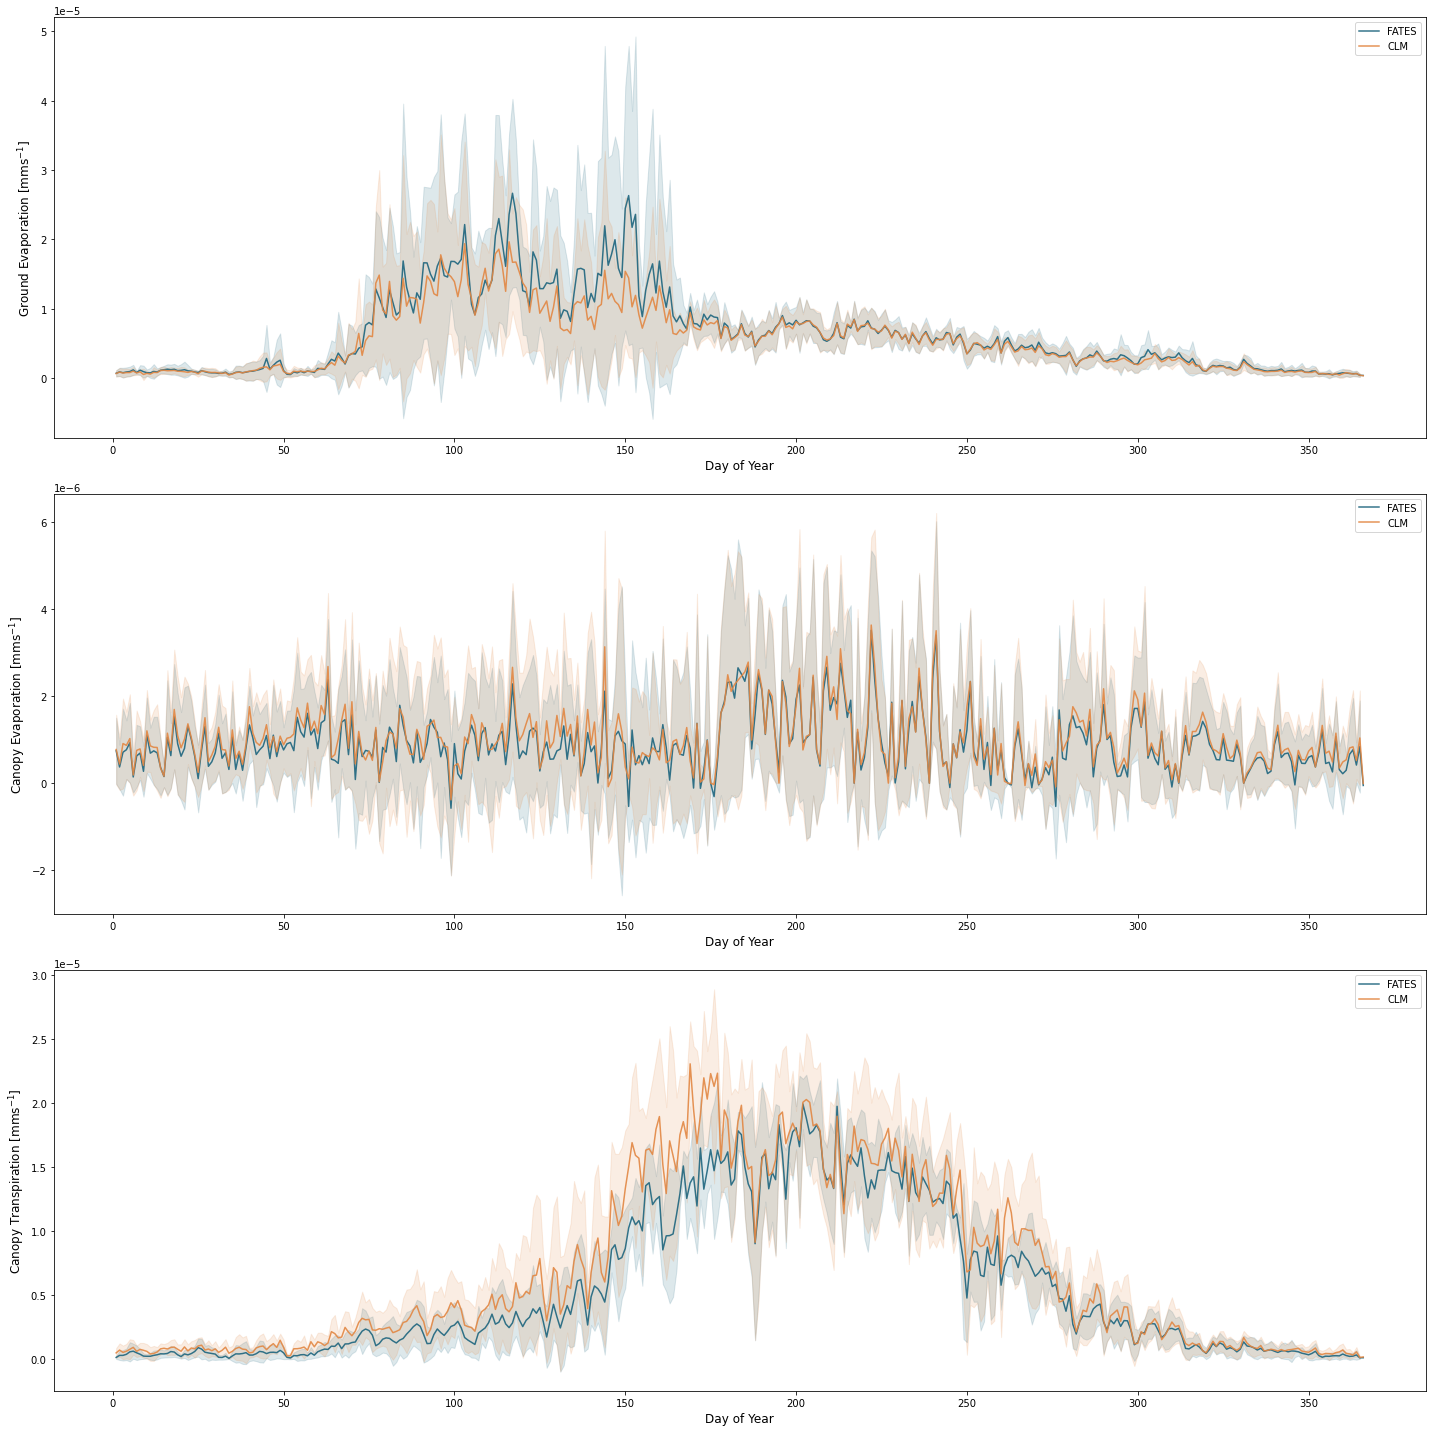

In [84]:
plt.figure(figsize=(20, 20),facecolor='w',edgecolor='k')

plt.subplot(3, 1, 1)
plot_var_desc = "Ground Evaporation"
plot_var_unit= "$\mathrm{mm  s^{-1}}$"
plt.plot(climo1.DOY, climo1['fates_sim_QSOIL'], color = color2, label="FATES", alpha = 0.9)
plt.plot(climo1.DOY, climo1['sim_QSOIL'], color = color1,label="CLM", alpha = 0.9)
plt.fill_between(climo1.DOY, climo1['fates_sim_QSOIL']-climo1SD['fates_sim_QSOIL'], climo1['fates_sim_QSOIL']+climo1SD['fates_sim_QSOIL'],alpha=0.15, color = color2)
plt.fill_between(climo1.DOY, climo1['sim_QSOIL']-climo1SD['sim_QSOIL'], climo1['sim_QSOIL']+climo1SD['sim_QSOIL'] ,alpha=0.15, color = color1)
plt.xlabel('Day of Year', fontsize=12)
plt.ylabel(plot_var_desc+" ["+plot_var_unit+"]", fontsize=12)
plt.legend()

plt.subplot(3, 1, 2)
plot_var_desc = "Canopy Evaporation"
plot_var_unit= "$\mathrm{mm  s^{-1}}$"
plt.plot(climo1.DOY, climo1['fates_sim_QVEGE'], color = color2, label="FATES", alpha = 0.9)
plt.plot(climo1.DOY, climo1['sim_QVEGE'], color = color1,label="CLM", alpha = 0.9)
plt.fill_between(climo1.DOY, climo1['fates_sim_QVEGE']-climo1SD['fates_sim_QVEGE'], climo1['fates_sim_QVEGE']+climo1SD['fates_sim_QVEGE'],alpha=0.15, color = color2)
plt.fill_between(climo1.DOY, climo1['sim_QVEGE']-climo1SD['sim_QVEGE'], climo1['sim_QVEGE']+climo1SD['sim_QVEGE'] ,alpha=0.15, color = color1)
plt.xlabel('Day of Year', fontsize=12)
plt.ylabel(plot_var_desc+" ["+plot_var_unit+"]", fontsize=12)
plt.legend()

plt.subplot(3, 1, 3)
plot_var_desc = "Canopy Transpiration"
plot_var_unit= "$\mathrm{mm  s^{-1}}$"
plt.plot(climo1.DOY, climo1['fates_sim_QVEGT'], color = color2, label="FATES", alpha = 0.9)
plt.plot(climo1.DOY, climo1['sim_QVEGT'], color = color1,label="CLM", alpha = 0.9)
plt.fill_between(climo1.DOY, climo1['fates_sim_QVEGT']-climo1SD['fates_sim_QVEGT'], climo1['fates_sim_QVEGT']+climo1SD['fates_sim_QVEGT'],alpha=0.15, color = color2)
plt.fill_between(climo1.DOY, climo1['sim_QVEGT']-climo1SD['sim_QVEGT'], climo1['sim_QVEGT']+climo1SD['sim_QVEGT'] ,alpha=0.15, color = color1)
plt.xlabel('Day of Year', fontsize=12)
plt.ylabel(plot_var_desc+" ["+plot_var_unit+"]", fontsize=12)
plt.legend()

plt.tight_layout()
plt.savefig('/glade/scratch/nict/fates4.png')
plt.show()

## Original

In [64]:
# put my own code here to read in (split into blocks)

# -- merge two pandas dataframe on time
df_all=df_all.merge(df_ctsm.set_index('time'), on='time', how='left')

'''
# merges sim and obs dataframes on time (pandas datetime same?, possibly convert)

df_all=df_ctsm

clm_var = 'sim_EFLX_LH_TOT'
# -- Latent Heat Flux:
# -- EFLX_LH_TOT = FCEV + FCTR +FGEV
df_all [clm_var] = df_all['sim_FCEV']+ df_all['sim_FCTR']+ df_all['sim_FGEV']

clm_var = 'sim_Rnet'
# -- Net Radiation:
# -- Rnet = FSA-FIRA
df_all [clm_var] = df_all ['sim_FSA']-df_all['sim_FIRA']

clm_var = 'sim_NEE'
# -- Net Ecosystem Exchange
# -- NEE = GPP- (AR+HR)
# -- It seems like the sign are opposite so we calculated negative NEE
df_all [clm_var] = -(df_all ['sim_GPP']-(df_all['sim_AR']+df_all['sim_HR']))

'''
# convert NEE units from  umolm-2s-1 to gc/m2/s
#df_all ['NEE']= df_all ['NEE']*(12.01/1000000)
#df_all ['GPP']= df_all ['GPP']*(12.01/1000000)

# -- convert gc/m2/s to gc/m2/day
df_all ['NEE']= df_all['NEE']*60*60*24
df_all ['GPP']= df_all['GPP']*60*60*24
'''
df_all ['sim_NEE']= df_all['sim_NEE']*60*60*24
df_all ['sim_GPP']= df_all['sim_GPP']*60*60*24
df_all ['sim_AR']= df_all['sim_AR']*60*60*24
df_all ['sim_HR']= df_all['sim_HR']*60*60*24
df_all ['sim_ER']= df_all['sim_HR']+df_all['sim_AR']

#-- extract year, month, day, hour information from time
df_all['year'] = df_all['time'].dt.year
df_all['month'] = df_all['time'].dt.month
df_all['day'] = df_all['time'].dt.day
df_all['hour'] = df_all['time'].dt.hour

#tzone_shift = ds_eval.TimeDiffUtcLt
# hard coded for Mountain time
tzone_shift = -7

#convert to local time
df_all['local_time']= df_all['time'] + datetime.timedelta(hours=int(tzone_shift))
df_all['local_hour'] = df_all['local_time'].dt.hour
df_all['site']=neon_site

# Write out 30 minute data
#csv_out = join(csv_dir, "preprocessed_"+neon_site+".csv")
#df_all.to_csv(csv_out,index=False)

#calculate daily means
df_all['local_date'] = df_all['local_time'].astype('M8[D]')
df_day = df_all.groupby(df_all['local_date']).mean()
#mask out days with missing values
df_count = df_all.groupby(df_all['local_date']).count()
df_day = df_day.where(df_count==48)

# Write out daily minute data
csv_out = join(csv_dir, "mean_daily_"+neon_site+".csv")
df_day.to_csv(csv_out,index=True)


end_site = time.time()
print ("Extracting data for "+neon_site+" took : ", end_site-start_site, "s.")
print ("Preprocessed file is saved as : ", csv_out)

except Exception as e: 
print (e)
print ('THIS SITE FAILED:', neon_site)
failed_sites.append(neon_site)
pass

SyntaxError: invalid syntax (2168988083.py, line 101)

In [8]:
ds_ctsm.H2OSOI


<xarray.DataArray 'H2OSOI' (time: 105120, lndgrid: 1)>
array([[0.3371491 ],
       [0.33714914],
       [0.33714914],
       ...,
       [0.2967561 ],
       [0.2967561 ],
       [0.2967561 ]], dtype=float32)
Coordinates:
  * time     (time) object '2016-01-01 00:00:00' ... '2021-12-29 23:30:00'
Dimensions without coordinates: lndgrid
Attributes:
    long_name:      volumetric soil water (natural vegetated and crop landuni...
    units:          mm3/mm3
    cell_methods:   time: mean
    landunit_mask:  veg

In [4]:
df1 = pd.read_csv('/glade/scratch/wwieder/preprocessed_neon_v2_dailyAR/mean_daily_US-NR1_hist.csv')
df2 = pd.read_csv('/glade/scratch/wwieder/preprocessed_neon_v2_dailyAR/mean_daily_US-NR1_aspen_hist.csv')

In [5]:
df1['time'] = pd.to_datetime(df1['local_date'],format= '%Y-%m-%d' )
df1['time2'] = pd.to_datetime(df1['local_date'],format= '%Y-%m-%d' )
df2['time'] = pd.to_datetime(df2['local_date'],format= '%Y-%m-%d' )
df2['time2'] = pd.to_datetime(df2['local_date'],format= '%Y-%m-%d' )
df1['DOY'] = df1['time'].dt.dayofyear
df2['DOY'] = df2['time'].dt.dayofyear
df1 = df1.set_index('time')
df2 = df2.set_index('time')

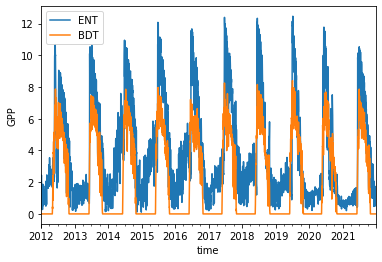

In [6]:
df1.sim_GPP.plot(label='ENT') ;
df2.sim_GPP.plot(label='BDT') ;
plt.ylabel('GPP');
plt.legend() ;

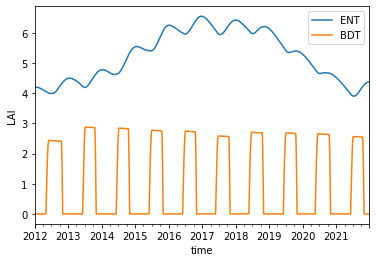

In [7]:
df1.sim_ELAI.plot(label='ENT') ;
df2.sim_ELAI.plot(label='BDT') ;
plt.ylabel('LAI');
plt.legend()


In [13]:
climo1 = df1.groupby(df1.time2.dt.dayofyear).mean()
climo2 = df2.groupby(df2.time2.dt.dayofyear).mean()
climo1SD = df1.groupby(df1.time2.dt.dayofyear).std()
climo2SD = df2.groupby(df2.time2.dt.dayofyear).std()
climo1.var()

sim_QVEGT          7.612738e-11
sim_QVEGE          5.040761e-12
sim_QSOIL          1.428320e-13
sim_RAIN           1.694962e-10
sim_SNOW           5.623734e-10
sim_Vcmx25Z        5.448288e+01
sim_AR             7.954230e-01
sim_ESAI           0.000000e+00
sim_HTOP           1.361325e-04
sim_ELAI           2.593255e-02
sim_FCEV           3.152996e+01
sim_FCTR           4.761768e+02
sim_FGEV           8.955892e-01
sim_FIRA           1.864355e+02
sim_FSA            3.328667e+03
sim_FSR            6.081036e+01
sim_FSDS           4.265845e+03
sim_FSH            1.293019e+03
sim_GPP            7.253402e+00
sim_H2OSOI         9.240332e-04
sim_HR             3.820276e+00
sim_SNOW_DEPTH     1.622973e-01
sim_TBOT           5.915313e+01
sim_TSOI           2.614165e+01
sim_BTRANMN                 NaN
sim_TV             5.216743e+01
sim_AGNPP          2.889708e-11
sim_EFLX_LH_TOT    4.414214e+02
sim_Rnet           2.979532e+03
sim_NEE            2.877460e-01
sim_ER             7.898760e+00
year    

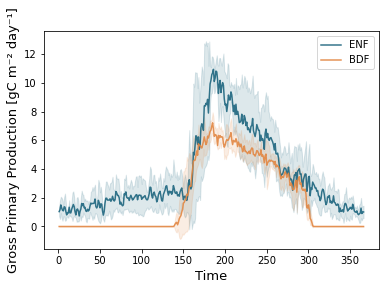

In [14]:
var = 'sim_GPP'
color1= '#e28743'
color2='#1d657e'

plot_var_desc = "Gross Primary Production"
plot_var_unit= "gC m⁻² day⁻¹"
#plot_var = var.obs_var
#sim_var = var.sim_var
#plot_var_desc = var.long_name
#lot_var_unit = var.unit
    
plt.plot ( climo1.DOY, climo1[var], color = color2, label="ENF", alpha = 0.9)
plt.plot ( climo2.DOY, climo2[var], color = color1,label="BDF", alpha = 0.9)
    
plt.fill_between(climo1.DOY, climo1[var]-climo1SD[var], climo1[var]+climo1SD[var],alpha=0.15, color = color2)
plt.fill_between(climo2.DOY, climo2[var]-climo2SD[var], climo2[var]+climo2SD[var] ,alpha=0.15, color = color1)

plt.xlabel('Time', fontsize=13)
plt.ylabel(plot_var_desc+" ["+plot_var_unit+"]", fontsize=13)
plt.legend();
#    ax.margins(x=0.02)


In [15]:
class PlotVariable ():
  def __init__(self, short_name, long_name, unit):
    self.short_name = short_name
    self.long_name = long_name
    self.unit = unit
    self.obs_var = short_name
    self.sim_var = 'sim_'+short_name

In [16]:
all_vars= [] 

plot_var = 'SNOW_DEPTH'
sim_var = 'sim_'+plot_var
plot_var_desc = "Snow Depth"
plot_var_unit= "m"
this_var = PlotVariable(plot_var, plot_var_desc, plot_var_unit)
all_vars.append(this_var)

plot_var = 'TSOI'
sim_var = plot_var
plot_var_desc = "Soil Temperature"
plot_var_unit= "deg C"
this_var = PlotVariable(plot_var, plot_var_desc, plot_var_unit)
all_vars.append(this_var)

plot_var = 'H2OSOI'
sim_var = 'sim_'+plot_var
plot_var_desc = "Soil Moisture"
plot_var_unit= "$\mathrm{mm^{3}  mm^{-3}}$"
this_var = PlotVariable(plot_var, plot_var_desc, plot_var_unit)
all_vars.append(this_var)

plot_var = 'GPP'
sim_var = 'sim_'+plot_var
plot_var_desc = "GPP"
plot_var_unit= "gC m⁻² day⁻¹"
this_var = PlotVariable(plot_var, plot_var_desc, plot_var_unit)
all_vars.append(this_var)

plot_var = 'HR'
sim_var = 'sim_'+plot_var
plot_var_desc = "HR"
plot_var_unit= "gC m⁻² day⁻¹"
this_var = PlotVariable(plot_var, plot_var_desc, plot_var_unit)
all_vars.append(this_var)


$\mathrm{mm^{3}  mm^{-3}}$

In [22]:
def shaded_tseries(climo1, climo1SD, climo2, climo2SD, var, ax, ln, unit, color1= '#e28743',color2='#1d657e' ):
    
    var = var.sim_var
    plot_var_desc = ln
    plot_var_unit = unit
    
    ax.plot ( climo1.DOY, climo1[var], color = color2, label="Spruce", alpha = 0.9)
    ax.plot ( climo2.DOY, climo2[var], color = color1,label="Aspen", alpha = 0.9)
    
    ax.fill_between(climo1.DOY, climo1[var]-climo1SD[var], climo1[var]+climo1SD[var],alpha=0.15, color = color2)
    ax.fill_between(climo2.DOY, climo2[var]-climo2SD[var], climo2[var]+climo2SD[var] ,alpha=0.15, color = color1)

    ax.set_xlabel('Time', fontsize=13)
    ax.set_ylabel(plot_var_desc+" ["+plot_var_unit+"]", fontsize=13)
    ax.margins(x=0.02)


In [23]:
var in enumerate(all_vars)

False

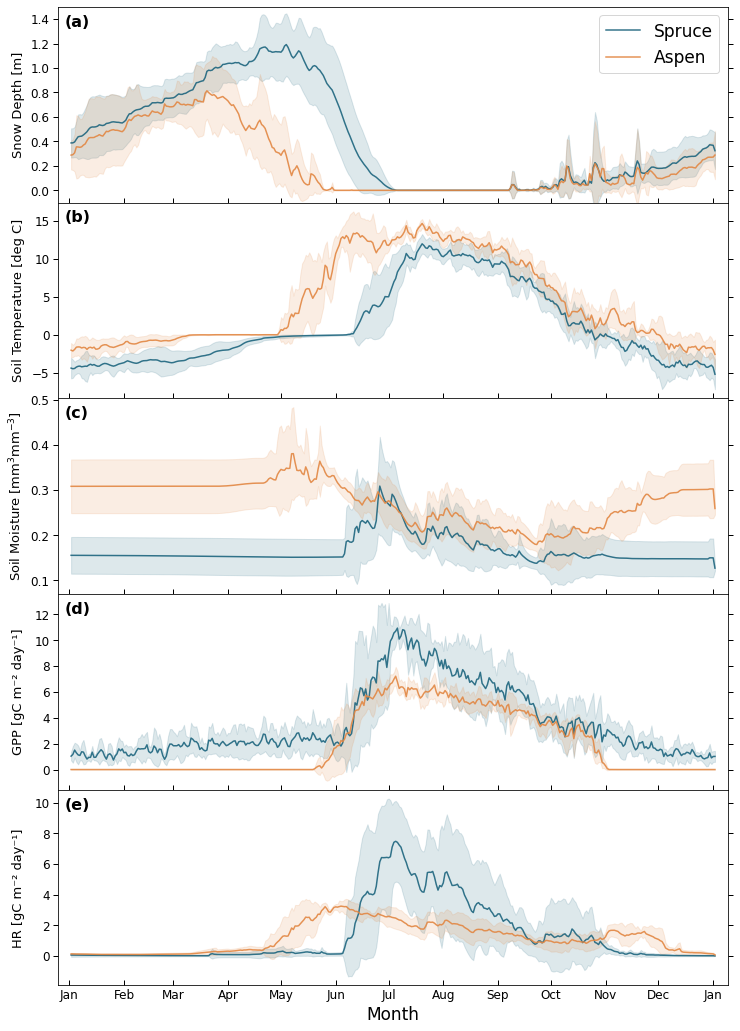

In [24]:
panel_labels = ["(a)", "(b)", "(c)", "(d)", "(e)"]
import matplotlib.dates as mdates

fig = plt.figure(num=None, figsize=(12, 18),  facecolor='w', edgecolor='k')
axes = fig.subplots(nrows=5, ncols=1)
axe = axes.ravel()
for index, var in enumerate(all_vars):
    ax = axe[index]    
    ln = var.long_name
    unit = var.unit
    
    shaded_tseries ( climo1, climo1SD, climo2, climo2SD, var, ax, ln, unit)

    ax.text(.01,0.90,panel_labels[index],
        horizontalalignment='left',
        transform=ax.transAxes, fontweight='bold',fontsize=16)

    # Set the locator for boxplots
    locator = mdates.MonthLocator()  # every month

    # Specify the format - %b gives us Jan, Feb...
    fmt = mdates.DateFormatter('%b')            

    # add a title
    if index == 0:
    #    ax.text(.5,1.03,'NEON site : '+neon_site + ' [2018-2021]',
    #    horizontalalignment='center',
    #    transform=ax.transAxes, fontweight='bold',fontsize=19)
        ax.legend(fontsize = 17)
        ax.set_ylim([-0.1,1.5])

    ax.tick_params(axis='both', which='both', labelsize=12,width=1,length=5)
    ax.tick_params(axis='x',direction="in", length = 5)
    ax.yaxis.set_ticks_position('both')
    ax.tick_params(axis='y',direction="out", length = 5)

    X=ax.xaxis
    X.set_major_locator(locator)
    X.set_major_formatter(fmt)

    ax.get_yaxis().set_label_coords(-0.05,0.5)

    if index == 5:
        X = plt.gca().xaxis
        X.set_major_locator(locator)
        X.set_major_formatter(fmt)

ax.set_xlabel('Month', fontsize=17)
fig.subplots_adjust(wspace=0, hspace=0)

plt.show()

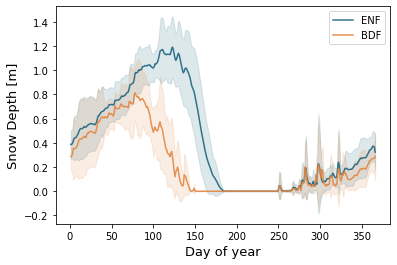

In [20]:
var = 'sim_SNOW_DEPTH'
color1= '#e28743'
color2='#1d657e'

plot_var_desc = "Snow Depth"
plot_var_unit= "m"
    
plt.plot ( climo1.DOY, climo1[var], color = color2, label="ENF", alpha = 0.9)
plt.plot ( climo2.DOY, climo2[var], color = color1,label="BDF", alpha = 0.9)
    
plt.fill_between(climo1.DOY, climo1[var]-climo1SD[var], climo1[var]+climo1SD[var],alpha=0.15, color = color2)
plt.fill_between(climo2.DOY, climo2[var]-climo2SD[var], climo2[var]+climo2SD[var] ,alpha=0.15, color = color1)

plt.xlabel('Day of year', fontsize=13)
plt.ylabel(plot_var_desc+" ["+plot_var_unit+"]", fontsize=13)
plt.legend();
#    ax.margins(x=0.02)


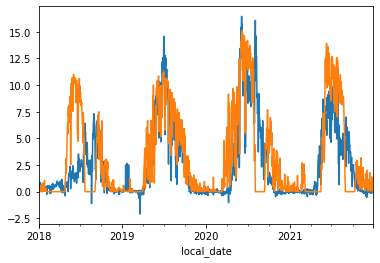

In [28]:
df_day.GPP.plot();
df_day.sim_GPP.plot();

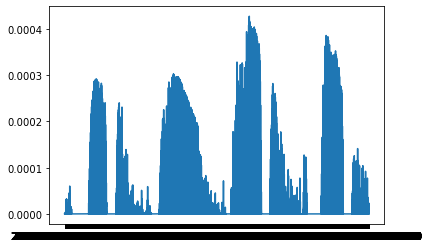

In [30]:
#ds_ctsm.FSDSNDLN.isel(lndgrid=0).plot() ;
plt.plot(ds_ctsm.time, ds_ctsm.GPP.isel(lndgrid=0)) ;